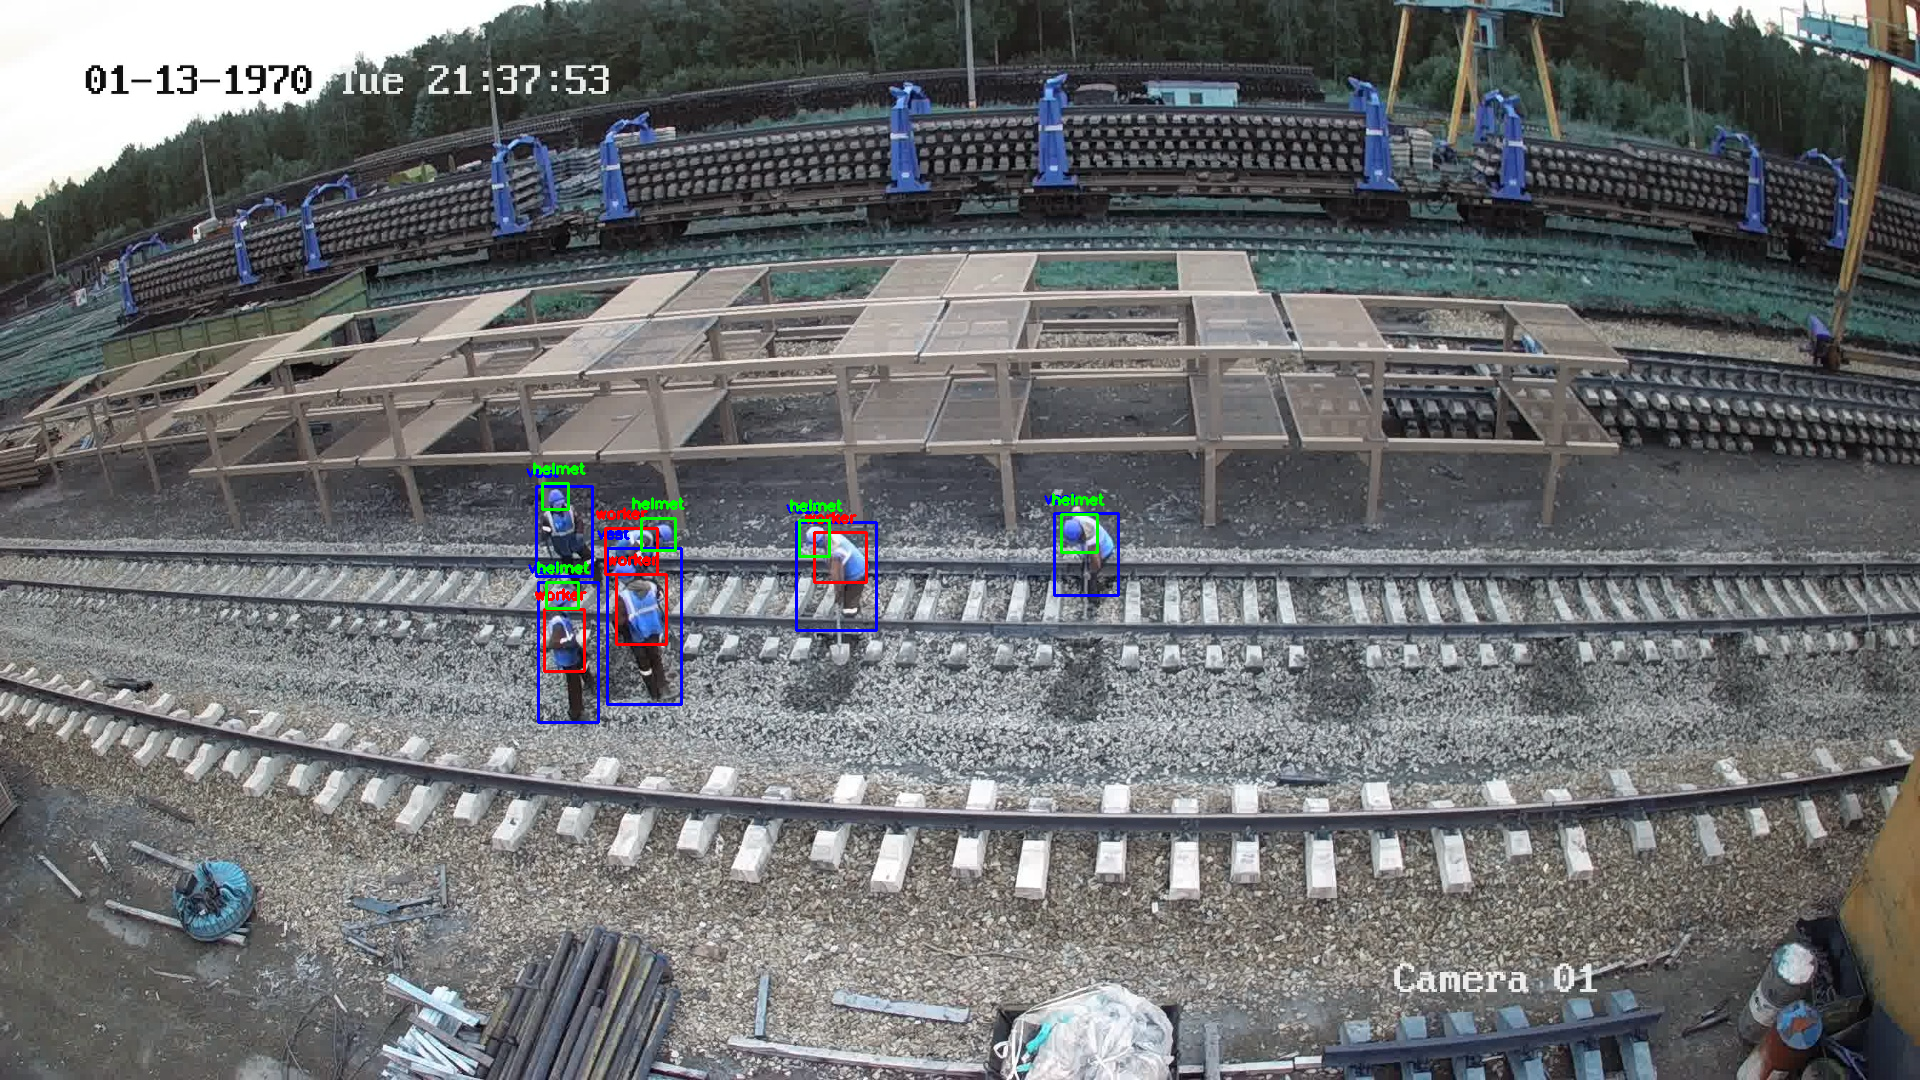

In [7]:
import cv2
import numpy as np
from PIL import Image

image_path = 'path_to_your_image'
config = '/darknet/yolo-obj.cfg' 
weights =  '/darknet/build/darknet/x64/backup/yolo-obj_5000.weights'
class_names = '/darknet/build/darknet/x64/data/obj.names'

with open(class_names, 'r') as f:
    classes = [line.strip() for line in f.readlines()]
    
COLORS = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]

image = cv2.imread(image_path)
Width = image.shape[1]
Height = image.shape[0]

def get_output_layers(net):
    layer_names = net.getLayerNames()
    output_layers = [layer_names[i-1] for i in net.getUnconnectedOutLayers()]
    return output_layers

def draw_prediction(img, class_id, confidence, x, y, x_plus_w, y_plus_h):
    label = str(classes[class_id])
    color = COLORS[class_id]
    cv2.rectangle(img, (x,y), (x_plus_w,y_plus_h), color, 2)
    cv2.putText(img, label, (x-10, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
def create_net_instance():
    scale = 0.00392    
    net = cv2.dnn.readNet(weights, config)
    blob = cv2.dnn.blobFromImage(image, scale, (416,416), (0,0,0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(get_output_layers(net))
    return outs

class_ids = []
confidences = []
boxes = []
conf_threshold = 0.5
nms_threshold = 0.4

outs = create_net_instance()

for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:
            center_x = int(detection[0] * Width)
            center_y = int(detection[1] * Height)
            w = int(detection[2] * Width)
            h = int(detection[3] * Height)
            x = center_x - w / 2
            y = center_y - h / 2
            class_ids.append(class_id)
            confidences.append(float(confidence))
            boxes.append([x, y, w, h])


indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)
for i in indices:
    box = boxes[i]
    x = box[0]
    y = box[1]
    w = box[2]
    h = box[3]
    draw_prediction(image, class_ids[i], confidences[i], round(x), round(y), round(x+w), round(y+h))

cv2.imwrite("object-detection.jpg", image)
Image.fromarray(image)